In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import sys 
import math

In [2]:
data = np.loadtxt('/home/echeveste/mis_trabajos/correlation_f_2/datos/dat_glx/data.dat')[:,:2]
rand = np.loadtxt('/home/echeveste/mis_trabajos/correlation_f_2/datos/dat_glx/rand0.dat')[:,:2]

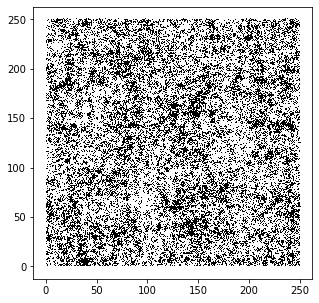

In [4]:
fig = plt.figure(figsize=(5,5))
plt.plot(data[:,0],data[:,1],'k,')

In [32]:
tam = 32
x = np.arange(math.floor(np.min(data[:,0])),math.ceil(np.max(data[:,0]))+tam,tam)
y = np.arange(math.floor(np.min(data[:,1])),math.ceil(np.max(data[:,1]))+tam,tam)

In [33]:
mallas = []
puntom = []
pm = tam/2

for i in range(len(x)-1):
    for j in range(len(y)-1):
        mallas.append(data[(data[:,0]>=x[i])&(data[:,0]<x[i+1])&(data[:,1]>=y[j])&(data[:,1]<y[j+1])])
        puntom.append([(tam/2)+i*tam,(tam/2)+j*tam])
puntom = np.array(puntom)

(-10.0, 260.0)

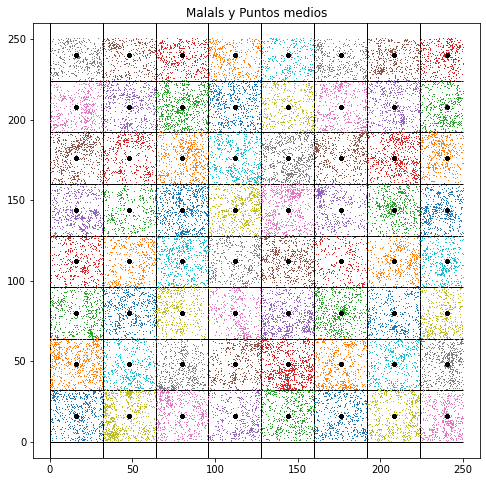

In [34]:
fig = plt.figure(figsize=(8,8))
plt.title('Malals y Puntos medios')
for i in range(len(mallas)):
    plt.plot(mallas[i][:,0],mallas[i][:,1],',')
    plt.plot(puntom[:,0],puntom[:,1],'k.')
    if i <= 250/tam:
        plt.axvline(i*tam, ymin=0, ymax =250 , linewidth=1, color = 'k')
        plt.hlines(i*tam, xmin=0, xmax=250, linewidth=1, color = 'k')
plt.xlim(-10,260)
plt.ylim(-10,260)

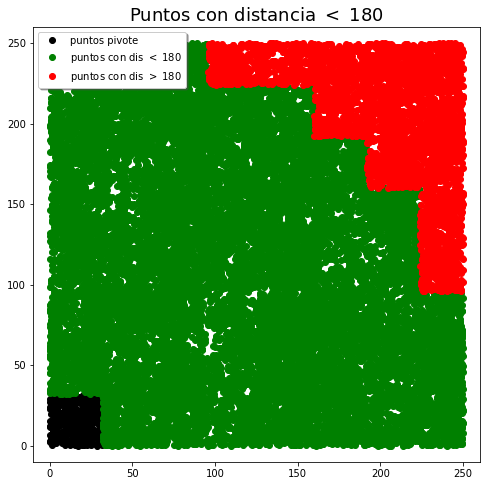

In [35]:
i = 0
dis_max = 180

pm = tam/2
s = puntom[i]-puntom[i+1:] 
dis = np.sqrt(s[:,0]**2+s[:,1]**2) - np.sqrt(3)*2*pm


pp =np.concatenate(np.array(mallas[i+1:],dtype=object)[dis<dis_max])
pp_=np.concatenate(np.array(mallas[i+1:],dtype=object)[dis>=dis_max])

fig = plt.figure(figsize=(8,8))
plt.plot(mallas[i][:,0],mallas[i][:,1],'ko',label='puntos pivote')
plt.plot(pp[:,0],pp[:,1],'go',label='puntos con dis $<$ {0}'.format(dis_max))
plt.plot(pp_[:,0],pp_[:,1],'ro',label='puntos con dis $>$ {0}'.format(dis_max))
plt.xlim(-10,260)
plt.ylim(-10,260)
plt.title('Puntos con distancia $<$ {0}'.format(dis_max),fontsize=18)
plt.legend(shadow=True, fontsize='10')

# PRUEBA

In [3]:
from joblib import Parallel, delayed

In [4]:
def make_mesh(data, size):
	"""
	Función para dividir los datos en nodos de un malla.
	
	data = Arreglo de puntos a dividir.
	size = tamaño de los nodos que componen la malla.
	"""
	# Límites de los nodos
	x = np.arange(math.floor(np.min(data[:,0])),math.ceil(np.max(data[:,0]))+size,size)
	y = np.arange(math.floor(np.min(data[:,1])),math.ceil(np.max(data[:,1]))+size,size)
	# Hacemos las mallas
	mesh = []
	pt_m = []
	d_pt_m = size/2 
	for i in range(len(x)-1):
		for j in range(len(y)-1):
			mesh.append(data[(data[:,0]>=x[i])&(data[:,0]<x[i+1])&(data[:,1]>=y[j])&(data[:,1]<y[j+1])])
			pt_m.append([d_pt_m+i*size, d_pt_m+j*size])
	pt_m = np.array(pt_m)
	return mesh, pt_m

In [5]:
def histo_XX_pll(data, bn, d_max):
	"""
	Función para hacer histogramas de distancias entre un mismo arreglo de puntos.
	
	data = Arreglo de puntos a dividir. 
	bn = bin de histograma.
	d_max = distancia maxima a medir.
	"""
	XX = np.zeros(bn)
	n = 0
	for ii in data:
		n = n+1
		s = ii-data[n:]
		dis, r = np.histogram(np.sqrt(s[:,0]**2+s[:,1]**2), bins=bn, range=(0, d_max))
		XX = XX + 2*dis
	return  XX

In [6]:
def histo_XY(p, p_r, bn, point_max):
	NDR = np.zeros(bn)
	for ii in p:
		s = ii-p_r
		dis, r = np.histogram(np.sqrt(s[:,0]**2+s[:,1]**2), bins=bn, range=(0, point_max))
		NDR = NDR + 2*dis
	return NDR

def histo_X_XY_pll(i, pt_m, d_pt_m, mesh, bn, d_max):
	"""
	Función para hacer histogramas de distancias entre un mismo arreglo de puntos usando cómputo en parallelo.
	
	i = ciclo.
	pt_m = Arreglo de puntos medios de cada nodo. 
	d_pt_m = mitad del la longitud del nodo.
	mesh = malla.
	bn = bin de histograma.
	d_max = distancia maxima a medir.
	"""	
	# Aproximación de distancia entre nodos con sus puntos medios
	s = pt_m[i]-pt_m[i+1:] 
	dx = pt_m[i][0]-pt_m[i+1:][:,0]
	dx[dx==0] = 0.000001 
	dy = pt_m[i][1]-pt_m[i+1:][:,1]
	m = np.abs(dy/dx)
	d_nodo = np.zeros_like(s[:,0])
	d_nodo[m<1] = np.sqrt(s[m<1][:,0]**2+s[m<1][:,1]**2)*(1-(2*d_pt_m/np.abs(dx[m<1])))
	d_nodo[m>1] = np.sqrt(s[m>1][:,0]**2+s[m>1][:,1]**2)*(1-(2*d_pt_m/np.abs(dy[m>1])))
	d_nodo[m==1.] = np.sqrt(s[m==1.][:,0]**2+s[m==1.][:,1]**2)-(2*d_pt_m*np.sqrt(2))    
	
	u = mesh[i] # Tomamos el i-esimo nodo de la malla  
	v = np.concatenate(np.array(mesh[i+1:],dtype=object)[d_nodo < d_max]) # Tomamos los siguientes nodos y hacemos un arreglo único
	
	XY = np.zeros(bn)
	for ii in u:
		s = ii-v
		dis, r = np.histogram(np.sqrt(s[:,0]**2+s[:,1]**2), bins=bn, range=(0, d_max))
		XY = XY + 2*dis
	return XY

In [7]:
def histo_X_XY_pll(i, pt_m, size, mesh, bn, d_max):
	"""
	Función para hacer histogramas de distancias entre un mismo arreglo de puntos usando cómputo en parallelo.
	
	i = ciclo.
	pt_m = Arreglo de puntos medios de cada nodo. 
	d_pt_m = mitad del la longitud del nodo.
	mesh = malla.
	bn = bin de histograma.
	d_max = distancia maxima a medir.
	"""	
	# Aproximación de distancia entre nodos con sus puntos medios
	s = pt_m[i]-pt_m[i+1:] 
	d_nodo = np.sqrt(s[:,0]**2+s[:,1]**2) - np.sqrt(2)*size
	u = mesh[i] # Tomamos el i-esimo nodo de la malla  
	v = np.concatenate(np.array(mesh[i+1:],dtype=object)[d_nodo < d_max]) # Tomamos los siguientes nodos y hacemos un arreglo único
	
	XY = np.zeros(bn)
	for ii in u:
		s = ii-v
		dis, r = np.histogram(np.sqrt(s[:,0]**2+s[:,1]**2), bins=bn, range=(0, d_max))
		XY = XY + 2*dis
	return XY

In [8]:
def histo_mesh_XX_pll(data, size, bn, d_max, nuc=2):
	"""
	Funcion principal para hecer histogramas XX de forma paralelizada
	
	data = datos.
	size = tamaño del lado de cada nodo.
	bn = bin del histograma.
	d_max = distancia maxima a medir.	
	"""
	mesh, pt_m = make_mesh(data, size)
	# Distacnias entre puntos del mismo nodo
	XX = np.sum(np.array(Parallel(n_jobs=nuc) #número de nucleos
				(delayed(histo_XX_pll) #Función 
				(ii, bn, d_max) for ii in mesh)), axis = 0 ) #Argumentos
	# Diastancias entre puntso de distinto nodo 
	XX = XX + np.sum(np.array(Parallel(n_jobs=nuc) #número de nucleos
					(delayed(histo_X_XY_pll) #Función para paralelizar
					(i, pt_m, size,
					mesh, bn, d_max) for i in range(len(pt_m)-2))), axis = 0 ) #Argumentos
	#Distancia entre el último nodo 			
	XX = XX + histo_XY(mesh[len(pt_m)-2],mesh[len(pt_m)-1],bn,d_max)
	
	return XX


In [9]:
def histo_XY_pll(i, pt_m, pt_m_r, size, mesh, mesh_r, bn, point_max):
	"""
	Función para hacer histogramas de distancias entre un mismo arreglo de puntos usando cómputo en parallelo.
	
	i = ciclo.
	pt_m = Arreglo de puntos medios de cada nodo de datos. 
	pt_m_r = Arreglo de puntos medios de cada nodo de los puntos aleatorios. 
	d_pt_m = mitad del la longitud del nodo.
	mesh = malla de datos.
	mesh_r = malla de puntos aleatorios.
	bn = bin de histograma.
	d_max = distancia maxima a medir.
	"""	
	s = pt_m[i]-pt_m_r 
	d_nodo = np.sqrt(s[:,0]**2+s[:,1]**2) - np.sqrt(2)*size
	
	u = mesh[i]
	v = np.concatenate(np.array(mesh_r,dtype=object)[d_nodo < point_max])
	
	XY = np.zeros(bn)
	for ii in u:
		s = ii-v
		dis, r = np.histogram(np.sqrt(s[:,0]**2+s[:,1]**2), bins=bn, range=(0, point_max))
		XY = XY + 2*dis
	return XY

In [10]:
def histo_mesh_XY_pll(data,rand,size,bn,point_max,nuc=2):
	"""
	Funcion principal para hecer histogramas XY de forma paralelizada
	
	data = datos.
	rand = puntos aleatorios
	size = tamaño del lado de cada nodo.
	bn = bin del histograma.
	d_max = distancia maxima a medir.	
	"""
	malla_D, malla_R =  Parallel(n_jobs=2)(delayed(make_mesh)(ii,size) for ii in [data,rand])        
	
	XY = np.sum(np.array(Parallel(n_jobs=nuc) #número de nucleos
					(delayed(histo_XY_pll) #Función 
					(i,malla_D[1],malla_R[1],size,malla_D[0],
					malla_R[0],bn,point_max) for i in range(len(malla_D[1])))),axis=0) #Argumentos
	return XY

In [36]:
size = 32

start = time.perf_counter()

DD_pll = histo_mesh_XX_pll (data,size,30,180)
RR_pll = histo_mesh_XX_pll (data,size,30,180)
DR_pll = histo_mesh_XY_pll (data,rand,size,30,180)

finish = time.perf_counter()
print(f'Finializó en {round(finish-start,2)} segundos')

Finializó en 28.63 segundos


In [38]:
DD_pll

array([ 2236770.,  5814102.,  9167686., 12285542., 15244752., 17823564.,
       20218452., 22441910., 24493748., 26406158., 28167716., 29764972.,
       31212374., 32453818., 33373562., 34238322., 34891778., 35486200.,
       35836092., 35874770., 35954686., 35788446., 35364750., 34844372.,
       34286996., 33634432., 32719402., 31775426., 30567994., 29370244.])